# Sistema de recomendacion de Item-Item

En la industria hotelera, conocer la experiencia de los clientes es de vital importancia, ya que de esta manera se pueden ofrecer múltiples alternativas que puedan mejorar dicha experiencia y permitan que los usuarios tengan un mejor desarrollo en sus viajes.

Un sistema de recomendación podría mejorar la experiencia de búsqueda en los siguientes viajes guiando al usuario, sugiriendo a manera de "porque te has hospedado en 'x' hotel, tal vez te gustaría estar en 'y' hotel cuando visites 'z' ciudad".

Esto se logra a partir de las visitas anteriores que el usuario valide en la plataforma.

El sistema que estaremos revisando a continuacion opera bajo el mismo principio.

## Dependencias

Pandas para nuestro Data Frame

Matplotlib y seaborn para visualizar los datos.

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## Cargando los datos

Tomados de Kaggle: [515K Hotel Reviews Data in Europe
](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe).

Esta base de datos tiene toda la información mezclada en un solo archivo, por lo que, además de la limpieza de los datos, tendremos que separarla para una mejor interpretación y análisis


In [ ]:
hotels_reviews = pd.read_csv("Hotel_Reviews.csv")
hotels_reviews.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


## Analisis Exploratorio

Se revisan los datos y se separan en dataframes que permitan su procesamiento. revisando cuántos ratings existen, hotels únicos y nacionalidades únicas

In [ ]:
n_reviews = len(hotels_reviews)
n_hotels = hotels_reviews['Hotel_Address'].nunique()
n_nationalities = hotels_reviews['Reviewer_Nationality'].nunique()

print(f"Total de Reviews: {n_reviews}")
print(f"Total de Hoteles: {n_hotels}")
print(f"Total de nacionalidades unicos: {n_nationalities}")
print(f"Promedio de ratings por Hotel: {round(n_reviews/n_hotels, 2)}")
print(f"Promedio de ratings por nacionalidad: {round(n_reviews/n_nationalities, 2)}")


Total de Reviews: 515738
Total de Hoteles: 1493
Total de nacionalidades unicos: 227
Promedio de ratings por Hotel: 345.44
Promedio de ratings por nacionalidad: 2271.97


In [ ]:
hotels_reviews.reset_index()
hotel_info = hotels_reviews[['Hotel_Name', 'Hotel_Address']].drop_duplicates(keep='first', ignore_index=True)
hotel_info.insert(0, 'hotel_id', range(0, len(hotel_info)))
hotel_info.insert(1, 'hotel_country', hotel_info['Hotel_Address'].str.split().str[-1])

hotel_info.loc[hotel_info['hotel_country'] == 'Kingdom', ['hotel_country']] = 'United Kingdom'

#hotel_info['hotel_country'].unique()
print(f"Total de Hoteles: {len(hotel_info)}")
hotel_info.head()


Total de Hoteles: 1494


,hotel_id,hotel_country,Hotel_Name,Hotel_Address
0,0,Netherlands,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
1,1,United Kingdom,K K Hotel George,1 15 Templeton Place Earl s Court Kensington a...
2,2,United Kingdom,Apex Temple Court Hotel,1 2 Serjeant s Inn Fleet Street City of London...
3,3,United Kingdom,The Park Grand London Paddington,1 3 Queens Garden Westminster Borough London W...
4,4,France,Monhotel Lounge SPA,1 3 Rue d Argentine 16th arr 75116 Paris France


In [ ]:
review_info = hotels_reviews[['Hotel_Address', 'Reviewer_Nationality', 'Negative_Review', 'Positive_Review', 'Reviewer_Score', 'Review_Date', 'Total_Number_of_Reviews_Reviewer_Has_Given']]

#review_info.loc[review_info['Hotel_Address'] == hotel_info['Hotel_Address'], 'Hotel_Address']
df = review_info.loc[:5].copy()
df1 = hotel_info.loc[:5].copy()
#df.loc[df.Hotel_Address.isin(df1.Hotel_Address), ['Hotel_Address']] = df1[['hotel_id']].values
#df['Hotel_Address'] = df.apply(lamda row: row['Hotel_Address'] if row)

# dictionary
hotel_dict = {row.Hotel_Address : row.hotel_id for (index, row) in hotel_info.iterrows()}
review_info = review_info.replace({"Hotel_Address":hotel_dict})
#print(hotel_dict)


review_info.columns = review_info.columns.str.replace('Hotel_Address', 'hotel_id')
review_info.head()

{' s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands': 0, '1 15 Templeton Place Earl s Court Kensington and Chelsea London SW5 9NB United Kingdom': 1, '1 2 Serjeant s Inn Fleet Street City of London London EC4Y 1LL United Kingdom': 2, '1 3 Queens Garden Westminster Borough London W2 3BA United Kingdom': 3, '1 3 Rue d Argentine 16th arr 75116 Paris France': 4, '1 5 Passage Ruelle 18th arr 75018 Paris France': 5, '1 8 Russell Square Camden London WC1B 5BE United Kingdom': 6, '1 Addington Street Lambeth London SE1 7RY United Kingdom': 7, '1 Aldwych Westminster Borough London WC2B 4BZ United Kingdom': 8, '1 Avenue Carnot 17th arr 75017 Paris France': 9, '1 Bis Rue De Vaugirard 6th arr 75006 Paris France': 10, '1 Hamilton Place Park Lane Westminster Borough London W1J 7QY United Kingdom': 11, '1 Impasse Marteau 18th arr 75018 Paris France': 12, '1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom': 13, '1 Kensington Court Kensington and Chelsea London W8 5DL United K

,hotel_id,Reviewer_Nationality,Negative_Review,Positive_Review,Reviewer_Score,Review_Date,Total_Number_of_Reviews_Reviewer_Has_Given
0,0,Russia,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9,8/3/2017,7
1,0,Ireland,No Negative,No real complaints the hotel was great great ...,7.5,8/3/2017,7
2,0,Australia,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1,7/31/2017,9
3,0,United Kingdom,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,3.8,7/31/2017,1
4,0,New Zealand,You When I booked with your company on line y...,Amazing location and building Romantic setting,6.7,7/24/2017,3


Total de ratings de los hoteles, utilizando `count()` y `groupby()`. Se agrupan los datos a partir de los ids de hoteles y se contabilizan el numero de ratings.

In [ ]:
user_freq = review_info[['Reviewer_Nationality', 'hotel_id']].groupby('Reviewer_Nationality').count().reset_index()
user_freq.columns = ['Reviewer_Nationality', 'n_ratings']
user_freq.head()

,Reviewer_Nationality,n_ratings
0,,523
1,Abkhazia Georgia,153
2,Afghanistan,8
3,Albania,286
4,Algeria,100


In [ ]:
print(f"Numero de reviews por nacionalidad: {user_freq['n_ratings'].mean():.2f}.")

Numero de reviews por nacionalidad: 2271.97.


<ipython-input-105-a63646514dd6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Reviewer_Score", data=review_info, palette="rocket")


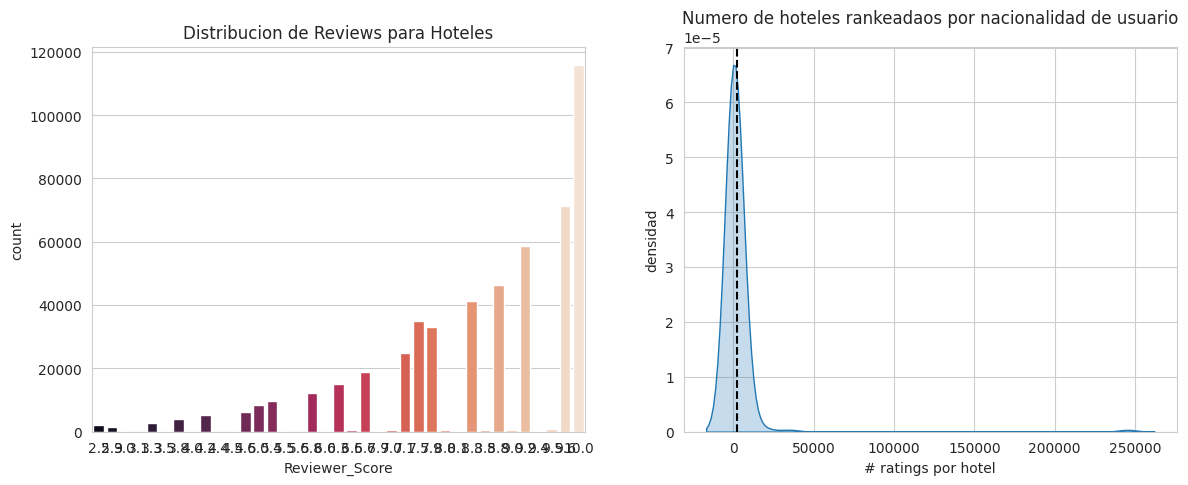

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="Reviewer_Score", data=review_info, palette="rocket")
plt.title("Distribucion de Reviews para Hoteles")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], fill=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings por hotel")
plt.ylabel("densidad")
plt.title("Numero de hoteles rankeadaos por nacionalidad de usuario")
plt.show()

### Si deseamos conocer cual es el hotel con el rating promedio mas bajo y cual es la que tiene el ranting mas alto?

In [ ]:
rating_media = review_info.groupby('hotel_id')[['Reviewer_Score']].mean()
print(f"Hotel con el rating mas bajo")
rating_bajo = rating_media['Reviewer_Score'].idxmin()
hotel_info.loc[hotel_info['hotel_id'] == rating_bajo]


Hotel con el rating mas bajo


,hotel_id,hotel_country,Hotel_Name,Hotel_Address
1444,1444,Italy,Hotel Liberty,Viale Bligny 56 Milan City Center 20136 Milan ...


In [ ]:
rating_alto = rating_media['Reviewer_Score'].idxmax()
print(f"Hotel con el rating mas alto")
hotel_info.loc[hotel_info['hotel_id'] == rating_alto]

Hotel con el rating mas alto


,hotel_id,hotel_country,Hotel_Name,Hotel_Address
156,156,France,Ritz Paris,15 Place Vend me 1st arr 75001 Paris France


Cantidad de ratings que tiene el mejor hotel.

In [ ]:
review_info[review_info['hotel_id']==rating_alto]

,hotel_id,Reviewer_Nationality,Negative_Review,Positive_Review,Reviewer_Score,Review_Date,Total_Number_of_Reviews_Reviewer_Has_Given
54717,156,United States of America,We had one odd moment when an attendant enter...,There is not much to stay about the Ritz It s...,9.6,7/14/2017,84
54718,156,Taiwan,View may not good Looking to your neighbor Fo...,Everying is perfect Beautiful hotel very nice...,10.0,5/27/2017,17
54719,156,Poland,No Negative,Absolutely amazing hotel Friendly and extraor...,10.0,4/18/2017,15
54720,156,South Africa,Difficult to get a seat when you feel like go...,Everything Service staff superbly trained and...,9.6,2/14/2017,3
54721,156,Qatar,Can t find anything,The staff and the property will make you feel...,10.0,2/11/2017,11
54722,156,United Kingdom,Prices are exorbitant My husband found it all...,It s the Ritz in Paris and looks feels and ac...,9.6,1/5/2017,2
54723,156,United Kingdom,In most five star hotels I usually have at le...,Stayed to celebrate our first anniversary and...,10.0,12/30/2016,6
54724,156,Australia,No Negative,Stayed at the Ritz to celebrate our recent we...,10.0,11/18/2016,2
54725,156,United States of America,very expensive but DELIVERS,this is fantasy we ask the staff for transpor...,9.6,7/27/2017,2
54726,156,United States of America,Rooms could be larger,Excellent hotel food and drinks exceptional R...,10.0,7/24/2017,1


Revisando los ratings, hay varios hoteles con calificaiones altas
La mejor manera de evaluar la popularidad de un hotel es utilizando Promedios Bayesianos.

## Promedio Bayesiano

Se define de la siguiente manera:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

Donde $C$ representa la confianza, $m$ representa el promedio aritmetico, y $N$ es el numero total de "reviews" de una pelicula $i$. En este caso, $m$ correspondera al promedio de ratings considerando todas las peliculas. Por definicion, C representa "el tamano tipico del dataset".


In [ ]:
hotel_stats = review_info.groupby('hotel_id')[['Reviewer_Score']].agg(['count', 'mean'])
hotel_stats.columns = hotel_stats.columns.droplevel()

In [ ]:
C = hotel_stats['count'].mean()
m = hotel_stats['mean'].mean()

def promedio_bayesiano(ratings):
    promedio_bayesiano = (C*m+ratings.sum())/(C+ratings.count())
    return promedio_bayesiano

ratings_promedio_bayesiano = review_info.groupby('hotel_id')['Reviewer_Score'].agg(promedio_bayesiano).reset_index()
ratings_promedio_bayesiano.columns = ['hotel_id', 'promedio_bayesiano']
hotel_stats = hotel_stats.merge(ratings_promedio_bayesiano, on='hotel_id')

In [ ]:
hotel_stats = hotel_stats.merge(hotel_info[['hotel_id', 'Hotel_Name', 'hotel_country']])
hotel_stats.sort_values('promedio_bayesiano', ascending=False).head()

,hotel_id,count,mean,promedio_bayesiano,Hotel_Name,hotel_country
25,25,2551,9.451196,9.333953,Intercontinental London The O2,United Kingdom
429,429,1113,9.368553,9.155284,Shangri La Hotel at The Shard London,United Kingdom
1289,1290,1837,9.266413,9.140060,Hotel Esther a,Netherlands
1398,1399,1052,9.339829,9.124351,Hotel Berna,Italy
1314,1315,785,9.391720,9.109491,Amba Hotel Charing Cross,United Kingdom


Con el Promedio Bayesiano se puede notar que el hotel `Intercontinental London The O2`, `Shangri La Hotel at The Shard London`, y `Hotel Esther` son los hoteles con las mejores reseñas.


¿Cuál es ahora e hotel con las peores reseñas según los Promedios Bayesianos?

In [ ]:
hotel_stats.sort_values('promedio_bayesiano', ascending=True).head()

,hotel_id,count,mean,promedio_bayesiano,Hotel_Name,hotel_country
186,186,4789,6.826644,6.937081,Britannia International Hotel Canary Wharf,United Kingdom
707,707,920,6.442065,6.995138,Hotel Cavendish,United Kingdom
593,593,953,6.554355,7.063497,Commodore Hotel,United Kingdom
374,374,1273,6.736685,7.106243,Bloomsbury Palace Hotel,United Kingdom
329,329,1107,6.785095,7.185376,Henry VIII,United Kingdom


Con los Promedios Bayesianos, los hoteles ubicados en United Kingdom `Britannia International Hotel Canary`, `Hotel Cavendish`, `Commodore Hotel` son de los que tienen las peores reseñas.

## Transformando los datos

Se utilizara una tecnica denominada [filtrado colaborativo](https://en.wikipedia.org/wiki/Collaborative_filtering) para generar recomendaciones para el usuario. Esta técnica parte de la suposicion de homogeneidad en los datos (usuarios similares les interesan las mismas cosas). El filtrado colaborativo es un tipo de aprendizaje no supervisado que realiza predicciones acerca de los intereses de un usuario al aprender de los intereses de una poblacion de gran tamaño.

El primer paso del filtrado colaborativo consiste en transformar los datos en una `matriz usuario-item (user-item matrix)`. En dicha matriz, las filas representan a los usuarios y las columnas representan a los items. El filtrado colaborativo no requiere de informacion sobre los usuarios o los items para generar las recomendaciones.


<img src="imagenes/user-movie-matrix.png" width="500px" align="left">

La funcion `create_X()` crea una matriz dispersa X a partir de 4 diccionarios de mapeo principales

- **mapeo_usuario:** mapea el ID usuario al indice del usuario
- **mapeo_pelicula:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

Requerimos de estos diccionarios porque mapean la fila y columna de la matriz de utilidad corresponden que ID de usuario e ID de película, respectivamente.

La matriz **X** (user-item) matrix es una matriz [scipy.sparse.csr_matrix](scipylinkhere) que almacena los datos de manera disperas.

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Genera una matriz dispersa a partir del dataframe de ratings

    Argumentos:
        df: dataframe en pandas

    Regresa:
        X: matriz dispersa
        mapeo_nacionalildad: dict que mapea las nacionalidades de los usuarios con los indices
        mapeo_inverso_nac: dict que mapea los indices con las nacionalidades de los usuarios
        mapeo_hotel: dict que mapea los id's de los hoteles con los indices de los hoteles
        mapeo_inverso_hotel: dict que mapea los indices de los hoteles con los id's de los hoteles
    """
    N = df['Reviewer_Nationality'].nunique()
    M = df['hotel_id'].nunique()

    mapeo_nacionalildad = dict(zip(np.unique(df["Reviewer_Nationality"]), list(range(N))))
    mapeo_hotel = dict(zip(np.unique(df["hotel_id"]), list(range(M))))

    mapeo_inverso_nac = dict(zip(list(range(N)), np.unique(df["Reviewer_Nationality"])))
    mapeo_inverso_hotel = dict(zip(list(range(M)), np.unique(df["hotel_id"])))

    user_index = [mapeo_nacionalildad[i] for i in df['Reviewer_Nationality']]
    movie_index = [mapeo_hotel[i] for i in df['hotel_id']]

    X = csr_matrix((df["Reviewer_Score"], (movie_index, user_index)), shape=(M, N))

    return X, mapeo_nacionalildad, mapeo_hotel, mapeo_inverso_nac, mapeo_inverso_hotel

In [ ]:
X, nac_mapper, hotel_mapper, nac_inv_mapper, hotel_inv_mapper = create_X(review_info)

Se calcula la dispersion de nuestra matriz X al dividir el total de elementos no ceros por el total de elementos.

In [ ]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Dispersion de la Matriz: {round(sparsity*100,2)}%")

Dispersion de la Matriz: 19.22%


Esto indica que el 19.22% de las celdas de la matriz nacionalidad-item tienen ratings. (Regularmente esto sucede en este tipo de matrices y como regla general la dispersion no debe ser menor a 0.5% para obtener resultados aceptables).

### Guardando la matriz a un archivo

Guardaremos la matriz usuario-item para el siguiente paso. Dado que nuestra matriz esta representada como una matriz dispersa scipy (scipy sparse matrix),utilizaremos el metodo [scipy.sparse.save_npz](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.sparse.load_npz.html) para guardar nuestra matriz como archivo.

In [ ]:
from scipy.sparse import save_npz

save_npz('datos/matriz_usuario_item.npz', X)



## Hallando Hoteles similares utilizando KNN (k-Nearest Neighbours)

Al utilizar esta estrategia, podemos hallar los $k$ vecinos de un hotel determinado al identificar los $k$ puntos en el dataset que estan mas cercanos al hotel $m$. kNN hace uso de metricas de distancias tales como:

1. Similaridad Coseno (Cosine similarity)
2. Distancia Euclidiana (Euclidean distance)
3. Distancia Manhattan (Manhattan distance)
4. Correlacion de Pearson (Pearson correlation )

Es un tanto cuanto dificil de visualizar, pero estamos trabajando en un espacio multidimensional M (donde M representa el numero de peliculas en nuestra matriz X)


In [ ]:
from sklearn.neighbors import NearestNeighbors

def encuentra_hoteles_parecidos(hotel_id, X, k, metric='cosine', show_distance=False):
    """
    Encuentra los k-vecinos para un pelicula dada (a partir de su id)

    Argumentos:
        hotel_id: id de la pelicula en cuestion
        X: matriz de utilidad usuario-item
        k: numero de peliculas similares a encontrar
        metric: metrica a utilizar para los calculos de kNN

    Devuelve:
        lista de k ID's de hotles similares
    """
    neighbour_ids = []

    hotel_ind = hotel_mapper[hotel_id]
    hotel_vec = X[hotel_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(hotel_vec, (np.ndarray)):
        hotel_vec = hotel_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(hotel_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(hotel_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`encuentra_hoteles_parecidas()` toma movie ID y la matriz user-item X, y despliega una lista de $k$ peliculas que son parecidas al hotelId en cuestion.

Crearemos ahora un mapeo de `hotelId` a `hotel` para que los resultados sean faciles de interpretar.

In [ ]:
nombre_hoteles = dict(zip(hotel_info['hotel_id'], hotel_info['Hotel_Name']))

hotel_id = 10

ids_parecidos = encuentra_hoteles_parecidos(hotel_id, X, k=5)
nombre_hotel = nombre_hoteles[hotel_id]

print(f"Por que te hospedaste en {nombre_hotel}")
print(f"Te pueden interesar los siguientes hoteles:")
for i in ids_parecidos:
    print(nombre_hoteles[i])

Por que te hospedaste en Hotel Trianon Rive Gauche
Te pueden interesar los siguientes hoteles:
K K Hotel Picasso
Le Parisis Paris Tour Eiffel
Avenida Palace
Hotel Barcelona Catedral
Holiday Inn Paris Notre Dame


Los resultados obtenidos muestran los 5 hoteles mas parecidas al Hotel Trianon Rive Gauche.

Se puede utilizar una metrica de distancia distinta, como euclidiana o manhattan en lugar de coseno.

In [ ]:
nombre_hoteles = dict(zip(hotel_info['hotel_id'], hotel_info['Hotel_Name']))

movie_id = 10
ids_parecidos = encuentra_hoteles_parecidos(hotel_id, X, k=5, metric="euclidean")

nombre_hotel = nombre_hoteles[hotel_id]
print(f"Porque fuiste al hotel {nombre_hotel}:")
print(f"Te pueden interesar los siguientes hoteles:")
for i in ids_parecidos:
    print(nombre_hoteles[i])

Porque fuiste al hotel Hotel Trianon Rive Gauche:
Te pueden interesar los siguientes hoteles:
NH Amsterdam Museum Quarter
U232 Hotel
Hotel Villa Emilia
Villa Panth on
Gallery Hotel
